In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import MaxPooling2D
from keras.callbacks import EarlyStopping
import random

IMG_SIZE = 28

In [4]:
def plotSamples(data,rows,cols,names,tLabels,pLabels=[]):
    fig, axs = plt.subplots(rows,cols)
    nDigits = data.shape[0]
    for i in range(rows):
        for j in range(cols):
            index = random.randint(0,nDigits-1)
            axs[i,j].imshow(data[index],cmap = 'gray')
            # remove axes titles
            axs[i,j].axis('off')
            if (np.any(pLabels)):
                axs[i,j].set_title('P: %s, T: %s' % (names[pLabels[index]], names[tLabels[index]]) ,fontdict={'fontsize': 10})
            else:
                axs[i,j].set_title('T: %s' % names[tLabels[index]],fontdict={'fontsize': 10})
            # show the figure
    plt.show()

In [5]:
def baseline_model():
	# create model
	model = Sequential()
	model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'))
	model.add(MaxPooling2D())
	model.add(Dropout(0.2))
	model.add(Flatten())
	model.add(Dense(64, activation='relu'))
	model.add(Dense(nClasses, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam',
               metrics=['accuracy'])
	return model

In [6]:
def plotTrainingCurves(history,numEpochs):
  #Process ploting
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_accuracy'])
  plt.plot(history.history['val_loss'])
  plt.axis([0,numEpochs,0,1])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Accuracy','loss','val_accuracy','val_loss'])
  plt.show()

In [7]:
# view original images with an augmented image
def visualize(original, augmented, title=""):
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original,cmap = 'gray')

  plt.subplot(1,2,2)
  plt.title(title + " image")
  plt.imshow(augmented,cmap='gray')
  plt.show()

In [8]:
# image augmentation tensor model
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),  # ±18°
    tf.keras.layers.RandomZoom(0.2),  # Random zoom in/out
    tf.keras.layers.RandomTranslation(0.2, 0.2),  # Random shift (10% height & width)
])

In [9]:
# Apply it in map() — runs on GPU if model runs on GPU
def augment(image,label):
    image = data_augmentation(image, training=True)  # important: training=True
    return image,label

In [10]:
names = ["0", "1", "2", "3", "4","5", "6", "7", "8", "9"]

In [11]:
(trainData, trainLabels), (testData, testLabels) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainData.shape, trainLabels.shape))
print('Test: X=%s, y=%s' % (testData.shape, testLabels.shape))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


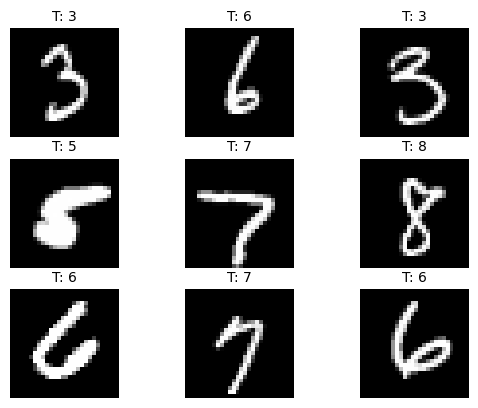

In [12]:
rows = 3
cols = 3

plotSamples(trainData,rows,cols,names,trainLabels)

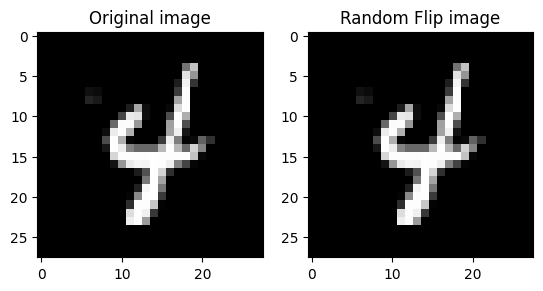

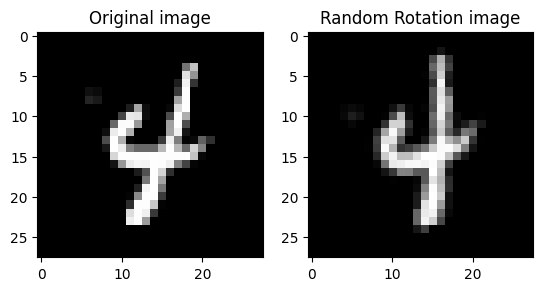

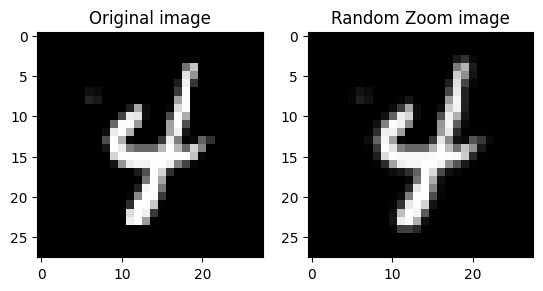

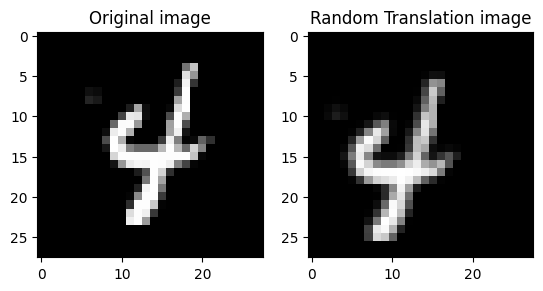

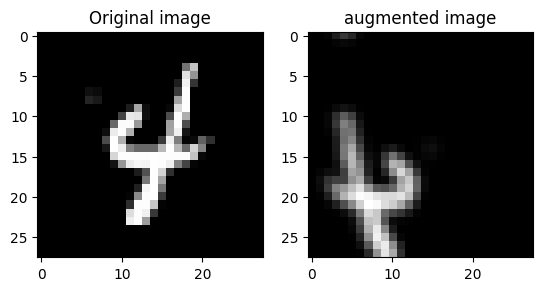

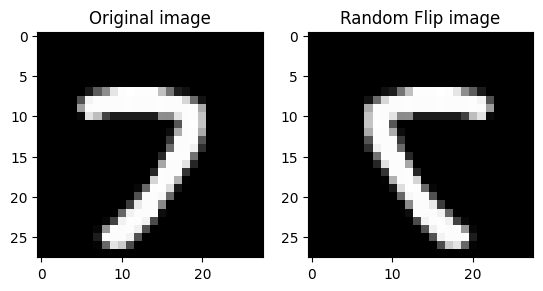

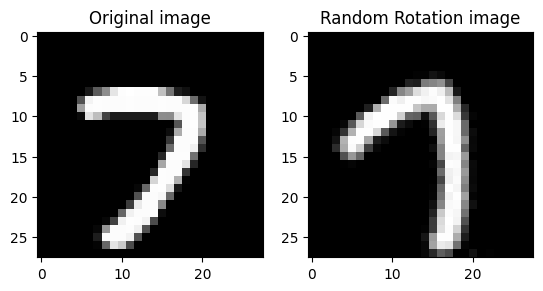

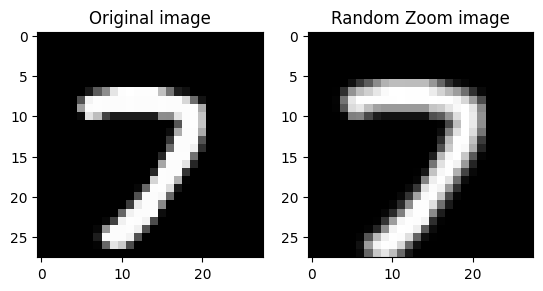

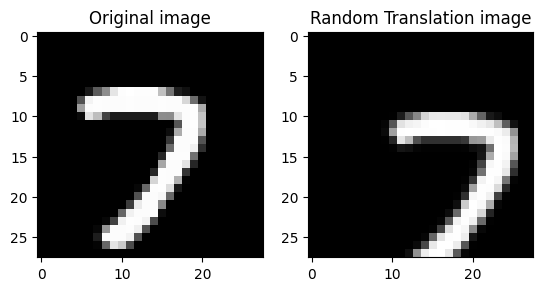

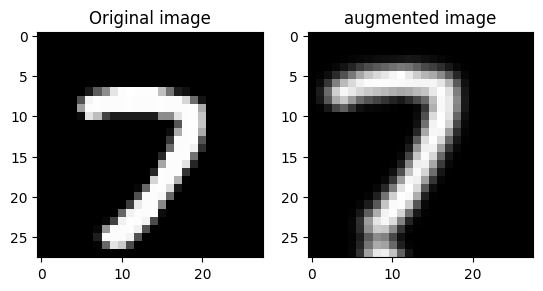

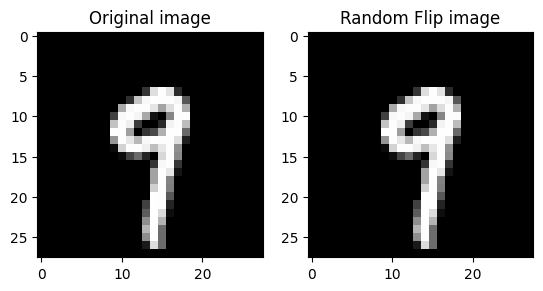

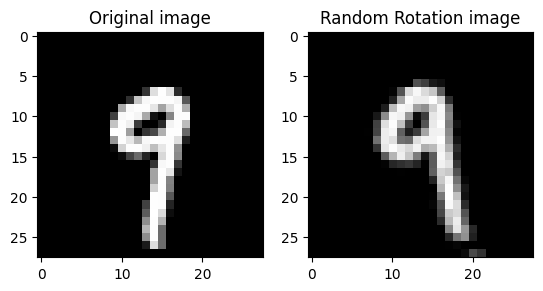

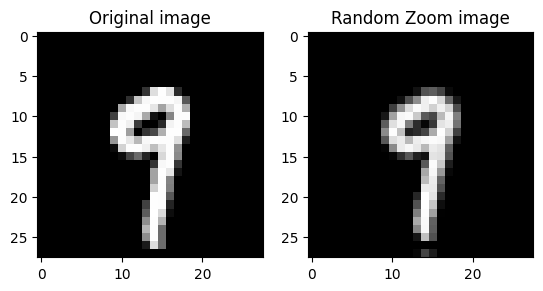

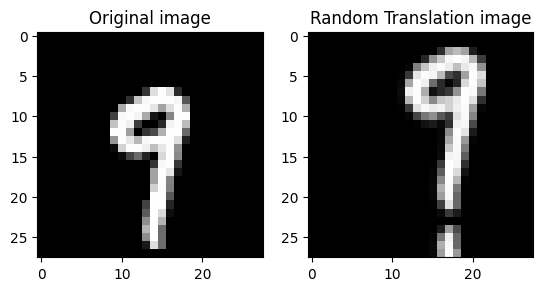

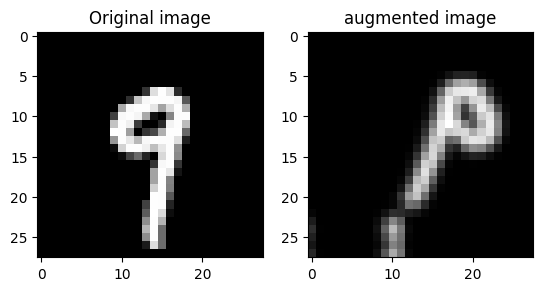

In [13]:
# image data augmentations

for i in range(3):
    index = index = random.randint(0,trainData.shape[0])
    image = trainData[index].reshape(28,28,1)

    # random flip
    randomFlip = tf.keras.layers.RandomFlip("horizontal")
    flippedImage = randomFlip(image)
    visualize(image,flippedImage,"Random Flip")

    # ±18° rotation
    randomRotation = tf.keras.layers.RandomRotation(0.1)
    rotatedImage = randomRotation(image)
    visualize(image,rotatedImage,"Random Rotation")

    # Random zoom in/out
    randomZoom = tf.keras.layers.RandomZoom(0.2)
    zoomedImage = randomZoom(image)
    visualize(image,zoomedImage,"Random Zoom")

    # Random shift (20% height & width)
    randomTranslation = tf.keras.layers.RandomTranslation(0.2, 0.2)
    translatedImage = randomTranslation(image)
    visualize(image, translatedImage,"Random Translation")

    #data augmentation
    augmentedImage = data_augmentation(image)
    visualize(image, augmentedImage,"augmented")

In [14]:
trainData = trainData.reshape((trainData.shape[0], 28, 28, 1)).astype('float32')
testData = testData.reshape((testData.shape[0], 28, 28, 1)).astype('float32')

catTrainLabels = to_categorical(trainLabels,num_classes=10)
catTestLabels = to_categorical(testLabels,num_classes=10)
trainData = trainData/255.0
testData = testData/255.0

In [15]:
batch_size = 64
AUTOTUNE = tf.data.AUTOTUNE
# generate a tensor train flow data set
train_ds = (
    tf.data.Dataset.from_tensor_slices((trainData, catTrainLabels))
    .shuffle(10000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .cache()
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [16]:
# generate a tensor test flow data set
test_ds = (
    tf.data.Dataset.from_tensor_slices((testData, catTestLabels))
    .map(augment, num_parallel_calls=AUTOTUNE)
    .cache()
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [17]:
nClasses = catTestLabels.shape[1]
# train the model
model = baseline_model()
nEpochs = 15

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=2,          # Stop if no improvement for 2 epochs
    verbose=1,           # Print a message when stopping
    mode='min',          # Stop when the loss is no longer decreasing
    restore_best_weights=True # Restore the best weights found
)

In [19]:
history = model.fit(train_ds, validation_data=test_ds, epochs=nEpochs,callbacks=[early_stopping])

Epoch 1/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 88s 92ms/step - accuracy: 0.4576 - loss: 1.5546 - val_accuracy: 0.7572 - val_loss: 0.7452
Epoch 2/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 39ms/step - accuracy: 0.7569 - loss: 0.7392 - val_accuracy: 0.8066 - val_loss: 0.5835
Epoch 3/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 39ms/step - accuracy: 0.8078 - loss: 0.5801 - val_accuracy: 0.8315 - val_loss: 0.5139
Epoch 4/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.8361 - loss: 0.4978 - val_accuracy: 0.8500 - val_loss: 0.4648
Epoch 5/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - accuracy: 0.8531 - loss: 0.4472 - val_accuracy: 0.8565 - val_loss: 0.4395
Epoch 6/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 40ms/step - accuracy: 0.8690 - loss: 0.3970 - val_accuracy: 0.8636 - val_loss: 0.4159
Epoch 7/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.8802 - loss: 0.3627 - val_accuracy: 0.8699 - val_loss: 0.4037
Epoch 8/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.8919 - loss: 0.3326 - 

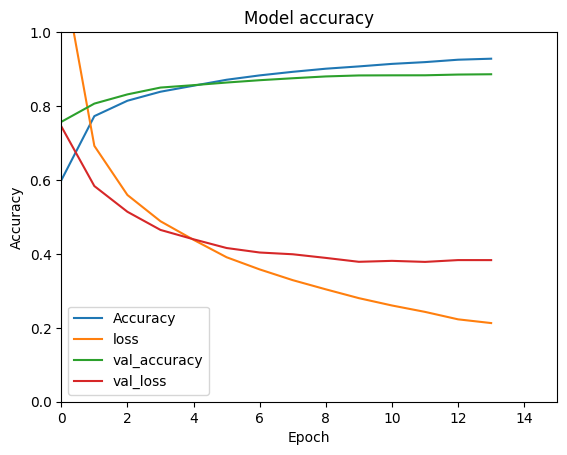

In [20]:
plotTrainingCurves(history,nEpochs)

In [21]:
# predicted the test data
predLabels = model.predict(testData).argmax(1)
cm_aug, acc_aug = per_digit_accuracy(testLabels, predLabels)

print("Accuracy per digit (AUGMENTED):")
for k in acc_aug:
    print(f"Digit {k}: {acc_aug[k]:.3f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Accuracy per digit (AUGMENTED):
Digit 0: 0.899
Digit 1: 0.947
Digit 2: 0.851
Digit 3: 0.950
Digit 4: 0.983
Digit 5: 0.914
Digit 6: 0.732
Digit 7: 0.929
Digit 8: 0.899
Digit 9: 0.786


In [22]:
# unpack tensor to augmented test numpy arry
augmentedTestData = tf.concat([x for x, y in test_ds], axis=0).numpy()

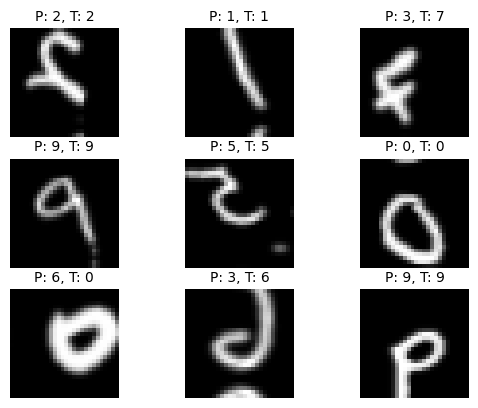

In [23]:
plotSamples(augmentedTestData,rows,cols,names,testLabels,predLabels)

task 1

In [24]:
from sklearn.metrics import confusion_matrix

def per_digit_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    acc_per_digit = {}

    for i in range(10):
        correct = cm[i, i]
        total = cm[i].sum()
        acc_per_digit[i] = correct / total

    return cm, acc_per_digit

In [25]:
train_ds_noaug = (
    tf.data.Dataset.from_tensor_slices((trainData, catTrainLabels))
    .shuffle(10000)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

test_ds_noaug = (
    tf.data.Dataset.from_tensor_slices((testData, catTestLabels))
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [26]:
model_noaug = baseline_model()
history_noaug = model_noaug.fit(
    train_ds_noaug,
    validation_data=test_ds_noaug,
    epochs=nEpochs,
    callbacks=[early_stopping]
)

Epoch 1/15


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


938/938 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.8925 - loss: 0.3641 - val_accuracy: 0.9804 - val_loss: 0.0609
Epoch 2/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 39ms/step - accuracy: 0.9802 - loss: 0.0650 - val_accuracy: 0.9859 - val_loss: 0.0431
Epoch 3/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 36s 38ms/step - accuracy: 0.9849 - loss: 0.0478 - val_accuracy: 0.9864 - val_loss: 0.0404
Epoch 4/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 43s 40ms/step - accuracy: 0.9877 - loss: 0.0393 - val_accuracy: 0.9868 - val_loss: 0.0380
Epoch 5/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step - accuracy: 0.9896 - loss: 0.0315 - val_accuracy: 0.9873 - val_loss: 0.0395
Epoch 6/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9920 - loss: 0.0259 - val_accuracy: 0.9889 - val_loss: 0.0370
Epoch 7/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 39ms/step - accuracy: 0.9935 - loss: 0.0196 - val_accuracy: 0.9870 - val_loss: 0.0396
Epoch 8/15
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - accuracy: 0.9947 - loss: 0.0161 - val_accurac

In [27]:
predLabels_noaug = model_noaug.predict(testData).argmax(1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [28]:
cm_noaug, acc_noaug = per_digit_accuracy(testLabels, predLabels_noaug)

print("\nAccuracy per digit (NO AUGMENTATION):")
for k in acc_noaug:
    print(f"Digit {k}: {acc_noaug[k]:.3f}")


Accuracy per digit (NO AUGMENTATION):
Digit 0: 0.995
Digit 1: 0.999
Digit 2: 0.994
Digit 3: 0.995
Digit 4: 0.979
Digit 5: 0.990
Digit 6: 0.984
Digit 7: 0.980
Digit 8: 0.987
Digit 9: 0.985


In [29]:
def plot_confusion_matrix(cm, names, title="Confusion Matrix"):
    plt.figure(figsize=(6,5))
    plt.imshow(cm, cmap="Blues")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(names))
    plt.xticks(ticks, names)
    plt.yticks(ticks, names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


Accuracy per digit (AUGMENTED):
Digit 0: 0.899
Digit 1: 0.947
Digit 2: 0.851
Digit 3: 0.950
Digit 4: 0.983
Digit 5: 0.914
Digit 6: 0.732
Digit 7: 0.929
Digit 8: 0.899
Digit 9: 0.786


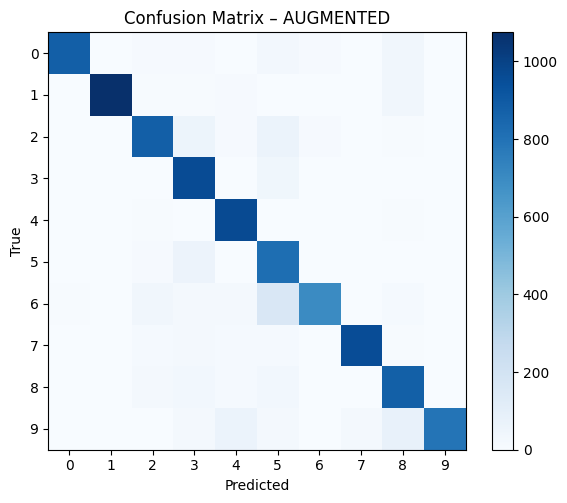

In [30]:
cm_aug, acc_aug = per_digit_accuracy(testLabels, predLabels)

print("\nAccuracy per digit (AUGMENTED):")
for d in range(10):
    print(f"Digit {d}: {acc_aug[d]:.3f}")

plot_confusion_matrix(cm_aug, names, "Confusion Matrix – AUGMENTED")


Accuracy per digit (NO AUGMENTATION):
Digit 0: 0.995
Digit 1: 0.999
Digit 2: 0.994
Digit 3: 0.995
Digit 4: 0.979
Digit 5: 0.990
Digit 6: 0.984
Digit 7: 0.980
Digit 8: 0.987
Digit 9: 0.985


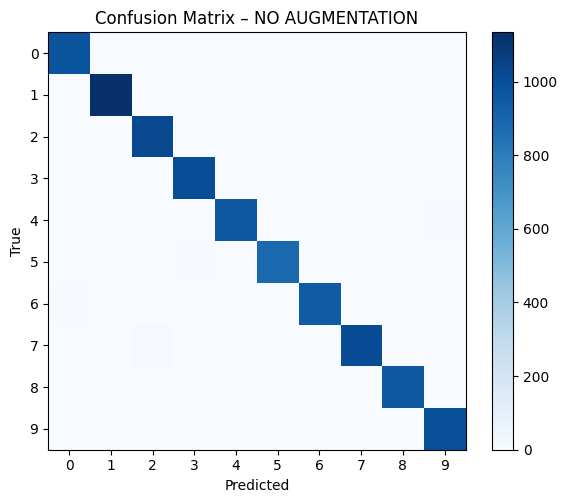

In [31]:
cm_noaug, acc_noaug = per_digit_accuracy(testLabels, predLabels_noaug)

print("\nAccuracy per digit (NO AUGMENTATION):")
for d in range(10):
    print(f"Digit {d}: {acc_noaug[d]:.3f}")

plot_confusion_matrix(cm_noaug, names, "Confusion Matrix – NO AUGMENTATION")

task 2

In [32]:
# stronger augmentation v2
data_augmentation_v2 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # includes vertical flip
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.25),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
])

In [33]:
def augment_v2(image, label):
    image = data_augmentation_v2(image, training=True)

    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

In [34]:
train_ds_aug_v2 = (
    tf.data.Dataset.from_tensor_slices((trainData, catTrainLabels))
    .shuffle(10000)
    .map(augment_v2, num_parallel_calls=AUTOTUNE)
    .cache()
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


938/938 ━━━━━━━━━━━━━━━━━━━━ 76s 75ms/step - accuracy: 0.3283 - loss: 1.8676 - val_accuracy: 0.7320 - val_loss: 0.7883
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 41ms/step - accuracy: 0.6206 - loss: 1.1280 - val_accuracy: 0.7795 - val_loss: 0.6114
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 39ms/step - accuracy: 0.7045 - loss: 0.8965 - val_accuracy: 0.8199 - val_loss: 0.5418
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 39ms/step - accuracy: 0.7424 - loss: 0.7848 - val_accuracy: 0.8228 - val_loss: 0.5373
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - accuracy: 0.7665 - loss: 0.7077 - val_accuracy: 0.8250 - val_loss: 0.5524
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 50s 53ms/step - accuracy: 0.7825 - loss: 0.6564 - val_accuracy: 0.8330 - val_loss: 0.5309
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 69s 39ms/step - accuracy: 0.7953 - loss: 0.6156 - val_accuracy: 0.8272 - val_loss: 0.5629
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - accuracy: 0.8075 - loss: 0.5817 - val_accurac

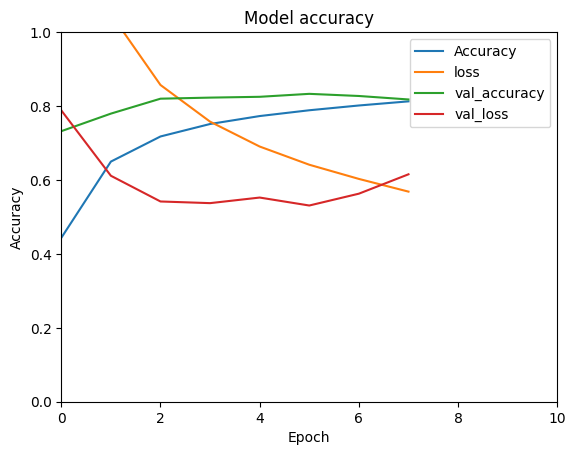

In [35]:
model_aug_v2 = baseline_model()
nEpochs_v2 = 10  # you can change

history_aug_v2 = model_aug_v2.fit(
    train_ds_aug_v2,
    validation_data=test_ds_noaug,
    epochs=nEpochs_v2,
    callbacks=[early_stopping]
)

plotTrainingCurves(history_aug_v2, nEpochs_v2)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

Accuracy per digit (AUGMENTATION v2):
Digit 0: 0.910
Digit 1: 0.910
Digit 2: 0.906
Digit 3: 0.816
Digit 4: 0.925
Digit 5: 0.860
Digit 6: 0.819
Digit 7: 0.811
Digit 8: 0.929
Digit 9: 0.443


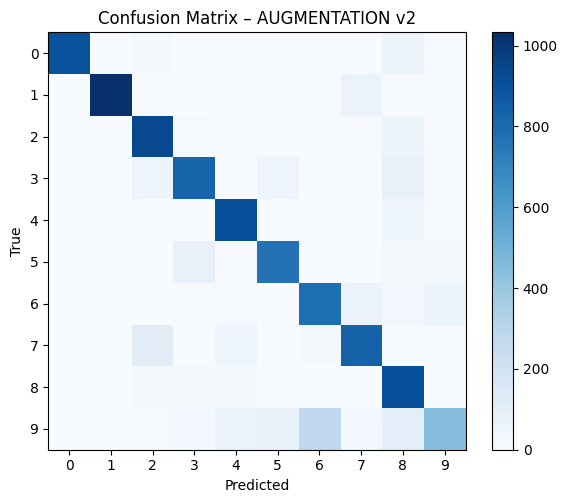

In [36]:
predLabels_aug_v2 = model_aug_v2.predict(testData).argmax(1)
cm_aug_v2, acc_aug_v2 = per_digit_accuracy(testLabels, predLabels_aug_v2)

print("\nAccuracy per digit (AUGMENTATION v2):")
for d in range(10):
    print(f"Digit {d}: {acc_aug_v2[d]:.3f}")

plot_confusion_matrix(cm_aug_v2, names, "Confusion Matrix – AUGMENTATION v2")

In [49]:
def compare_val_accuracy(histories, labels):
    for h in histories:
        plt.plot(h.history["val_accuracy"])
    plt.title("Validation Accuracy Comparison")
    plt.xlabel("Epoch")
    plt.ylabel("Val Accuracy")
    plt.legend(labels)
    plt.show()

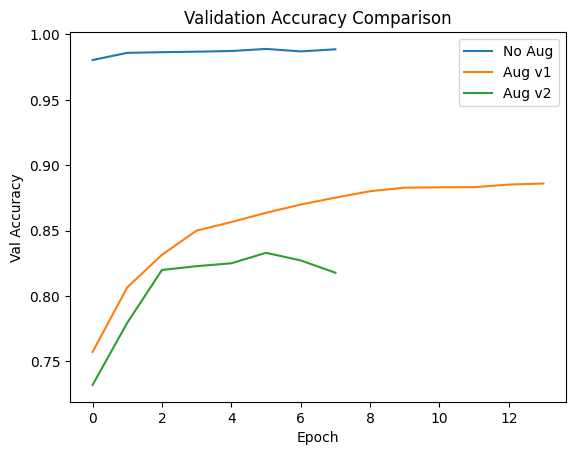

In [50]:
compare_val_accuracy(
    [history_noaug, history, history_aug_v2],
    ["No Aug", "Aug v1", "Aug v2"]
)

task 3

In [40]:
from keras.layers import BatchNormalization

In [45]:
def deeper_cnn_model():
    model = Sequential()

    # Original baseline
    model.add(Conv2D(32, (5, 5), input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.2))

    # ===== 2 NEW layers =====
    model.add(Conv2D(64, (3,3), activation='relu', padding='same'))  # +1
    model.add(MaxPooling2D((2,2)))                                  # +2

    # Head (same as before)
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nClasses, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


938/938 ━━━━━━━━━━━━━━━━━━━━ 75s 78ms/step - accuracy: 0.3836 - loss: 1.7318 - val_accuracy: 0.8136 - val_loss: 0.5392
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 67s 71ms/step - accuracy: 0.7441 - loss: 0.8023 - val_accuracy: 0.8612 - val_loss: 0.4125
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 67s 71ms/step - accuracy: 0.8182 - loss: 0.5748 - val_accuracy: 0.8888 - val_loss: 0.3410
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 65s 70ms/step - accuracy: 0.8494 - loss: 0.4684 - val_accuracy: 0.8995 - val_loss: 0.3201
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 66s 71ms/step - accuracy: 0.8699 - loss: 0.4027 - val_accuracy: 0.8896 - val_loss: 0.3614
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 66s 70ms/step - accuracy: 0.8872 - loss: 0.3543 - val_accuracy: 0.8927 - val_loss: 0.3554
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 4.


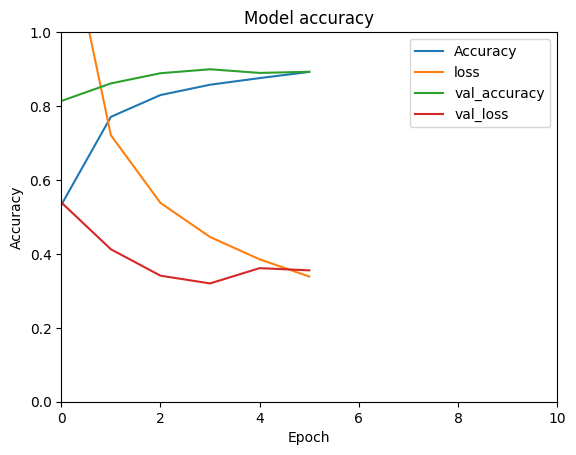

In [46]:
model_deep = deeper_cnn_model()
nEpochs_deep = 10

history_deep = model_deep.fit(
    train_ds_aug_v2,         # augmented train (v2)
    validation_data=test_ds_noaug,
    epochs=nEpochs_deep,
    callbacks=[early_stopping]
)

plotTrainingCurves(history_deep, nEpochs_deep)

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step

Accuracy per digit (DEEP CNN on AUG data):
Digit 0: 0.981
Digit 1: 0.958
Digit 2: 0.950
Digit 3: 0.975
Digit 4: 0.944
Digit 5: 0.904
Digit 6: 0.867
Digit 7: 0.905
Digit 8: 0.964
Digit 9: 0.544


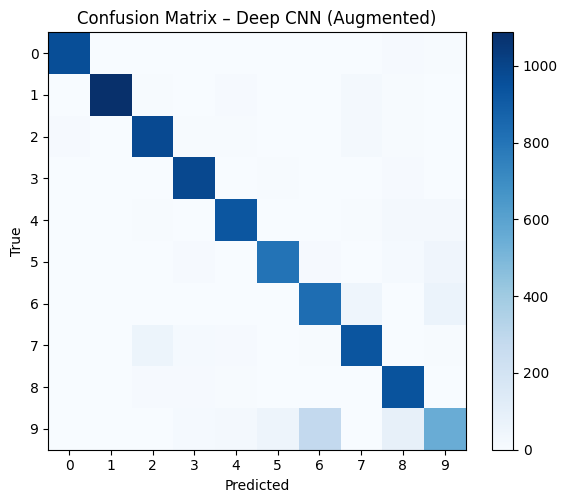

In [47]:
predLabels_deep = model_deep.predict(testData).argmax(1)
cm_deep, acc_deep = per_digit_accuracy(testLabels, predLabels_deep)

print("\nAccuracy per digit (DEEP CNN on AUG data):")
for d in range(10):
    print(f"Digit {d}: {acc_deep[d]:.3f}")

plot_confusion_matrix(cm_deep, names, "Confusion Matrix – Deep CNN (Augmented)")

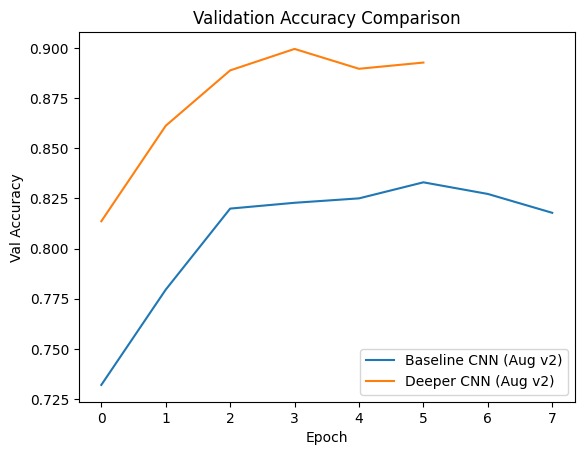

In [51]:
compare_val_accuracy(
    [history_aug_v2, history_deep],
    ["Baseline CNN (Aug v2)", "Deeper CNN (Aug v2)"]
)

task 4+5

In [63]:
import os
from tensorflow.keras.utils import load_img, img_to_array

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
def load_paint_digit(path):
    # load as grayscale
    img = load_img(path, color_mode="grayscale")
    img = img_to_array(img)  # shape (H,W,1), values 0..255

    # resize to 28x28
    img = tf.image.resize(img, (28, 28)).numpy()

    # normalize to 0..1
    img = img / 255.0

    # If you drew BLACK digit on WHITE background, invert:
    # (uncomment if predictions look wrong)
    # img = 1.0 - img

    return img  # (28,28,1)

In [65]:
def predict_with_models(models_dict, images, true_labels=None):

    X = np.stack(images, axis=0)

    results = {}
    for name, m in models_dict.items():
        probs = m.predict(X, verbose=0)
        preds = probs.argmax(axis=1)
        confs = probs.max(axis=1)
        results[name] = (preds, confs, probs)
    return X, results

def plot_predictions_grid(X, file_names, results, true_labels=None):
    N = X.shape[0]
    plt.figure(figsize=(12, 2.5 * N))

    row = 1
    for i in range(N):
        plt.subplot(N, 1, row)
        plt.imshow(X[i].squeeze(), cmap="gray")
        title = f"{file_names[i]}"
        if true_labels is not None:
            title += f" | True: {true_labels[i]}"

        # add predictions from each model
        for model_name, (preds, confs, _) in results.items():
            title += f" || {model_name}: {preds[i]} ({confs[i]:.2f})"

        plt.title(title)
        plt.axis("off")
        row += 1

    plt.tight_layout()
    plt.show()

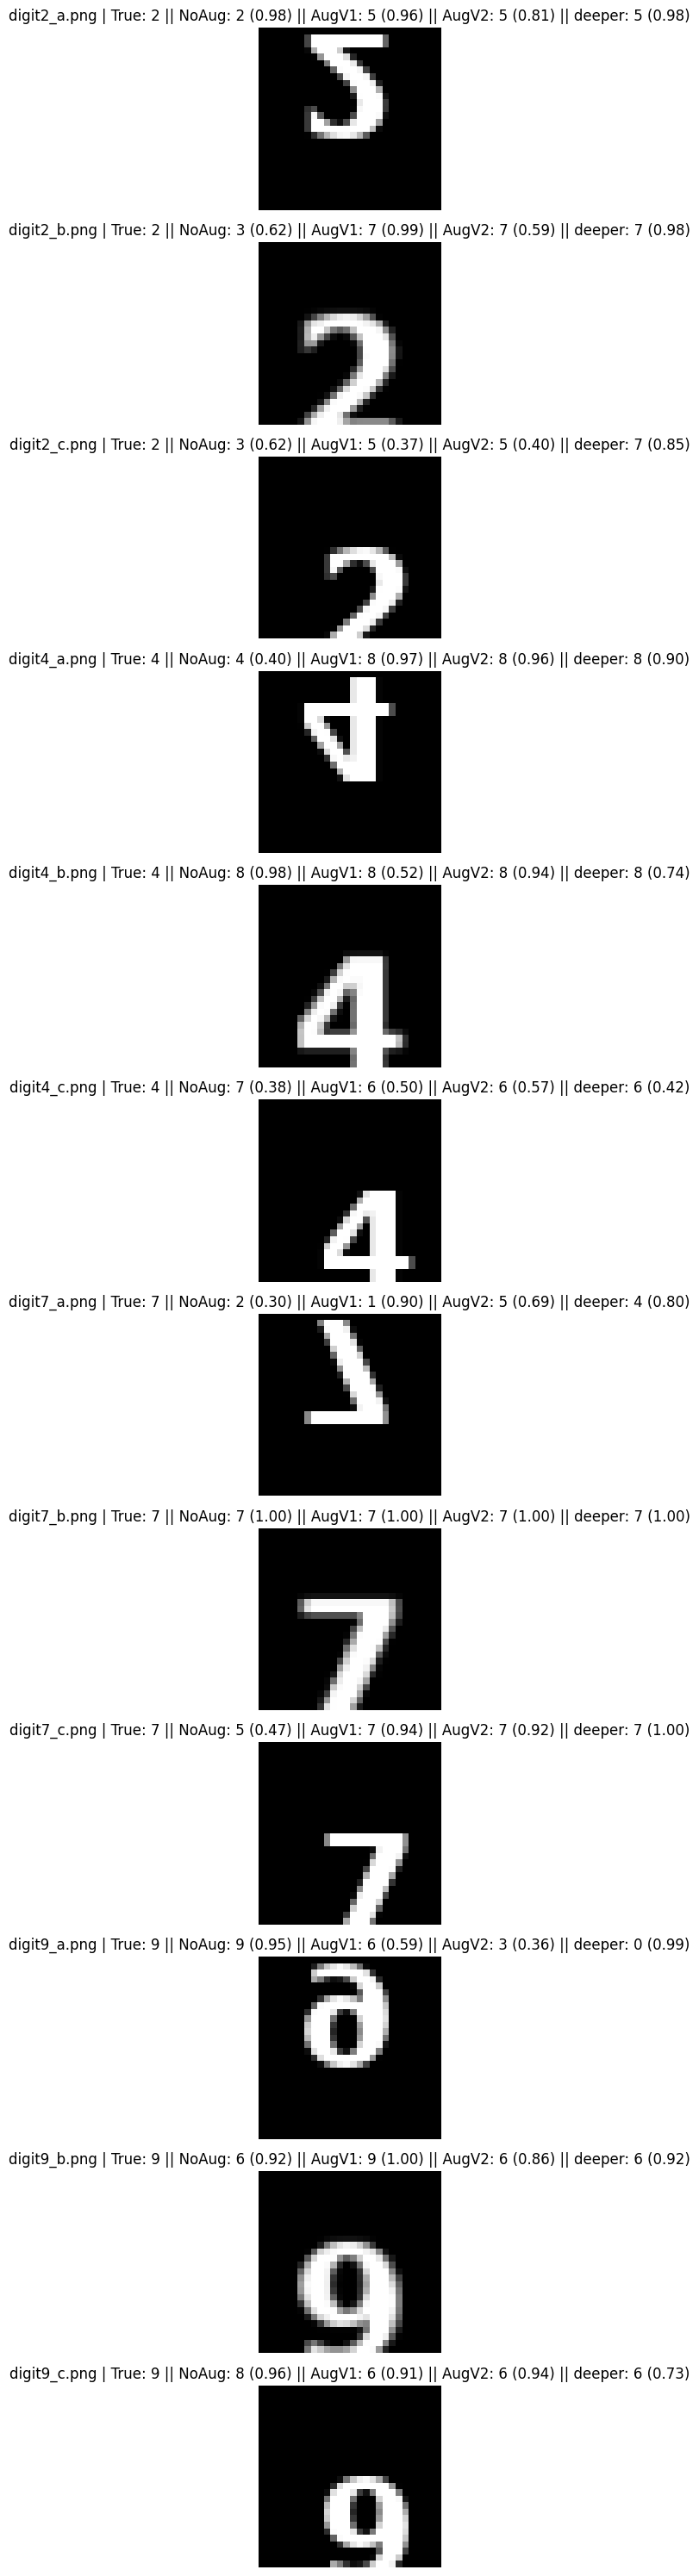

In [73]:
# Choose which trained models you want to compare:
# Use the variable names from your code.
models_dict = {
    "NoAug": model_noaug,
    "AugV1": model,             # your first augmented model
    "AugV2": model_aug_v2,       # if you trained it
    "deeper": model_deep        # if you trained it
}

folder = "/content/drive/MyDrive/digits"
files = sorted([f for f in os.listdir(folder) if f.lower().endswith(".png")])
paths = [os.path.join(folder, f) for f in files]

images = [load_paint_digit(p) for p in paths]

# If your filenames contain the true digit like "digit7_a.png", extract it:
true_labels = []
for f in files:
    # expects 'digitX_...' pattern
    d = int(f.replace("digit", "").split("_")[0])
    true_labels.append(d)

X, results = predict_with_models(models_dict, images, true_labels=true_labels)
plot_predictions_grid(X, files, results, true_labels=true_labels)

In [74]:
def accuracy_on_custom(results, true_labels):
    for model_name, (preds, confs, _) in results.items():
        acc = (preds == np.array(true_labels)).mean()
        print(f"{model_name} accuracy: {acc:.2f}")

accuracy_on_custom(results, true_labels)

NoAug accuracy: 0.33
AugV1 accuracy: 0.25
AugV2 accuracy: 0.17
deeper accuracy: 0.17
